In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd
from machinelearning_fedbatch import main, plot_net_predictions, validate_predictions
from system_ode_fedbatch import simulate, PlotSolution
from src.utils import get_data_and_feed, plot_experiment
import matplotlib.pyplot as plt

FILENAME = "../data/data_processed.xlsx"
EXPERIMENT = "BR01"
S_IN = 1.43 * 200

C:\Users\mexis\AppData\Local\Temp\ipykernel_1556\3201568664.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  full_df['Biomass'].iloc[1] = 5.0


Dataset shape: (12, 8)


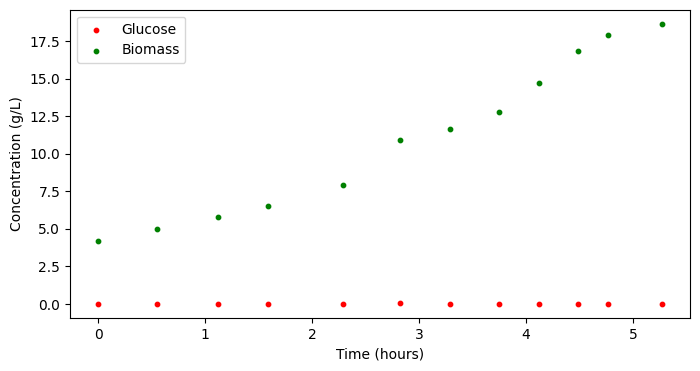

In [3]:
full_df, feeds = get_data_and_feed(
    file_name=FILENAME, experiment=EXPERIMENT, keep_only="FB"
)

full_df['Biomass'].iloc[1] = 5.0
# add new line to full_df
new_row = pd.DataFrame([{"Process": "FB", "RTime": 5.85, "V": 1.56, "Biomass": 5.8, "Glucose": 0.013, "Protein": 0.0}])
full_df = pd.concat([full_df, new_row], ignore_index=True)
full_df.sort_values(by="RTime", inplace=True)

T_FB = full_df["RTime"].iloc[0] # Time of fed-batch
T_START = 0
T_END = full_df["RTime"].iloc[-1] - T_FB  # End of experiment

# Get initial volume
V0 = full_df["V"].iloc[0]

# Normalize time
full_df["RTime"] = full_df["RTime"] - T_FB
feeds["Time"] = feeds["Time"] - T_FB

print(f"Dataset shape: {full_df.shape}")

plot_experiment(full_df, title='')

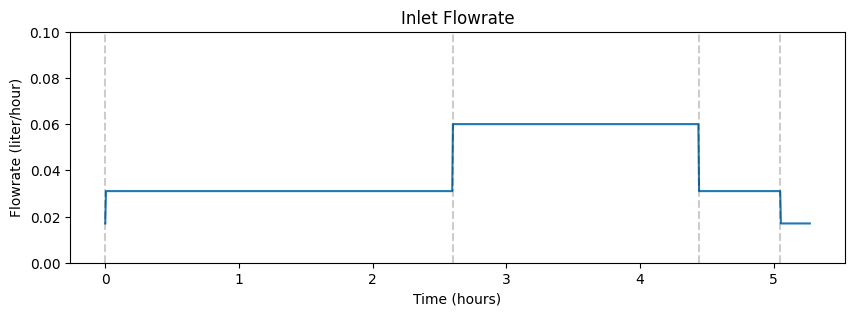

In [4]:
# inlet flowrate
def Fs(t):
    if t <= 4.73 - T_FB:
        return 0.017
    elif t <= 7.33 - T_FB:
        return 0.031
    elif t <= 9.17 - T_FB:
        return 0.060
    elif t <= 9.78 - T_FB:
        return 0.031
    else:
        return 0.017

# Plot Fs(t) 
Fs_t = [Fs(i) for i in np.linspace(T_START,T_END,1000)]
plt.figure(figsize=(10,3))
plt.plot(np.linspace(T_START,T_END,1000),Fs_t)
# Plot vertical lines on feed times
for feed_time in feeds["Time"]:
    plt.axvline(feed_time, color='black', alpha=0.2, linestyle='--')
plt.xlabel('Time (hours)')
plt.ylabel('Flowrate (liter/hour)')
plt.title('Inlet Flowrate')
plt.ylim(0,0.1)
plt.show()

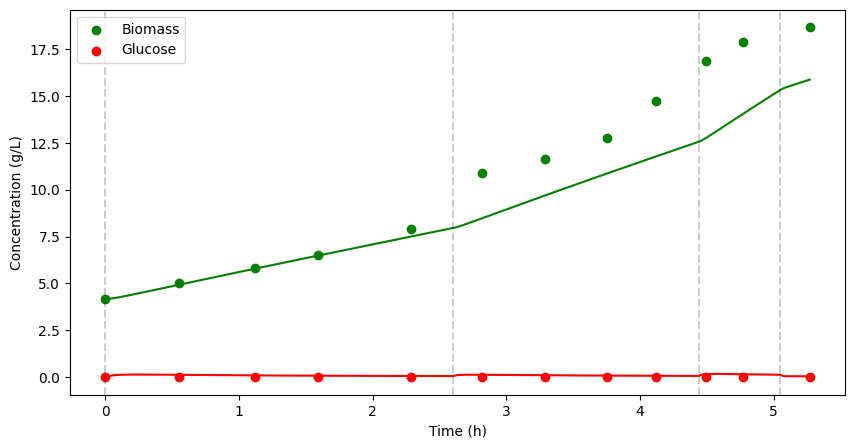

In [13]:
t_start = full_df["RTime"].iloc[0]
t_end = full_df["RTime"].iloc[-1]
IC = [full_df["Biomass"].iloc[0], full_df["Glucose"].iloc[0], V0]
sol_df = simulate(
    feeds,
    0.870,
    0.215,
    0.496,
    S_IN,
    t_start,
    t_end,
    NUM_SAMPLES=1000,
    IC=IC,
    return_df=True
)

plt.figure(figsize=(10, 5))
plt.scatter(full_df["RTime"], full_df["Biomass"], label="Biomass", color='green')
plt.plot(sol_df["RTime"], sol_df["Biomass"], label="_Biomass", color='green')
plt.scatter(full_df["RTime"], full_df["Glucose"], label="Glucose", color='red')
plt.plot(sol_df["RTime"], sol_df["Glucose"], label="_Glucose", color='red')
# Plot vertical lines on feed times
for feed_time in feeds["Time"]:
    plt.axvline(feed_time, color='black', alpha=0.2, linestyle='--')
plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.show()


In [6]:
for i in range(2, len(full_df)+1):
    print(f"Training with {i} samples")
    train_df = full_df.iloc[:i]
    net, u_pred, loss = main(train_df=train_df, full_df=full_df, feeds=feeds, Sin=S_IN, V0=V0, num_epochs=30000, verbose=100)
    
    # Clip u_pred to be positive
    u_pred[u_pred < 0] = 0
    
    print(f"mu_max = {net.mu_max.item():.4f}")
    print(f"Ks = {net.K_s.item():.4f}")
    print(f"Yxs = {net.Y_xs.item():.4f}")

    title = f"mu_max = {net.mu_max.item():.4f}, Ks = {net.K_s.item():.4f}, Yxs = {net.Y_xs.item():.4f} | Loss = {loss:.4f}"
    plot_net_predictions(full_df=full_df, train_df=train_df, u_pred=u_pred, title=title)
    
    validate_predictions(full_df=full_df, u_pred=u_pred, i=i)
    
    # Save u_pred to file
    u_pred.to_csv(f"./temp/u_pred_{i}.csv", index=False)

In [ ]:
t_start = full_df["RTime"].iloc[0]
t_end = full_df["RTime"].iloc[-1]
IC = [full_df["Biomass"].iloc[0], full_df["Glucose"].iloc[0], V0]
sol_df = simulate(
    feeds,
    net.mu_max.item(),
    net.K_s.item(),
    net.Y_xs.item(),
    S_IN,
    t_start,
    t_end,
    NUM_SAMPLES=1000,
    IC=IC,
    return_df=True
)

PlotSolution(full_df=full_df, train_df=train_df, df_pred=sol_df)

# Quick and dirty way to plot results

In [25]:
from sklearn.metrics import mean_squared_error

def plot_predictions(full_df: pd.DataFrame, res: pd.DataFrame, i: int) -> None:
    plt.figure(figsize=(10, 5))
    plt.scatter(full_df["RTime"], full_df["Biomass"], label="_Biomass", color='green', alpha=0.2)
    plt.scatter(full_df["RTime"].iloc[:i], full_df["Biomass"].iloc[:i], label="Biomass", color='green')
    plt.plot(res["RTime"], res["Biomass"], label="_Biomass", color='green')
    plt.scatter(full_df["RTime"], full_df["Glucose"], label="_Glucose", color='red', alpha=0.2)
    plt.scatter(full_df["RTime"].iloc[:i], full_df["Glucose"].iloc[:i], label="Glucose", color='red')
    plt.plot(res["RTime"], res["Glucose"], label="_Glucose", color='red')
    plt.xlabel("Time (h)")
    plt.ylabel("Concentration (g/L)")
    plt.legend()
    plt.show()
    
def validate_predictions(full_df: pd.DataFrame, u_pred: pd.DataFrame, i: int) -> None:
    """ Validate the prediction accuracy of the PINN

    :param full_df: Full training dataset
    :type full_df: pd.DataFrame
    :param u_pred: Predictions of the PINN 
    :type u_pred: pd.DataFrame
    :param i: Number of training data points used for training
    :type i: int
    """
    print('************************************************************************')
    print('************************************************************************')
    
    full_df['Biomass_pred'] = u_pred['Biomass'].values
    full_df['Glucose_pred'] = u_pred['Glucose'].values
    try:
        next_biomass = full_df['Biomass'].iloc[i]
        next_glucose = full_df['Glucose'].iloc[i]
        pred_biomass = full_df['Biomass_pred'].iloc[i]
        pred_glucose = full_df['Glucose_pred'].iloc[i]
        print(f'Biomass error: {abs(next_biomass - pred_biomass):.4f}')
        print(f'Glucose error: {abs(next_glucose - pred_glucose):.4f}')
        print(f'Real Biomass: {next_biomass:.4f} || Predicted Biomass: {pred_biomass:.4f}')
        print(f'Real Glucose: {next_glucose:.4f} || Predicted Glucose: {pred_glucose:.4f}')  
    except IndexError:
        pass
    biomass_mse = mean_squared_error(full_df['Biomass'], full_df['Biomass_pred'])
    glucose_mse = mean_squared_error(full_df['Glucose'], full_df['Glucose_pred'])
    print(f'Biomass MSE: {biomass_mse:.4f}')
    print(f'Glucose MSE: {glucose_mse:.4f}')


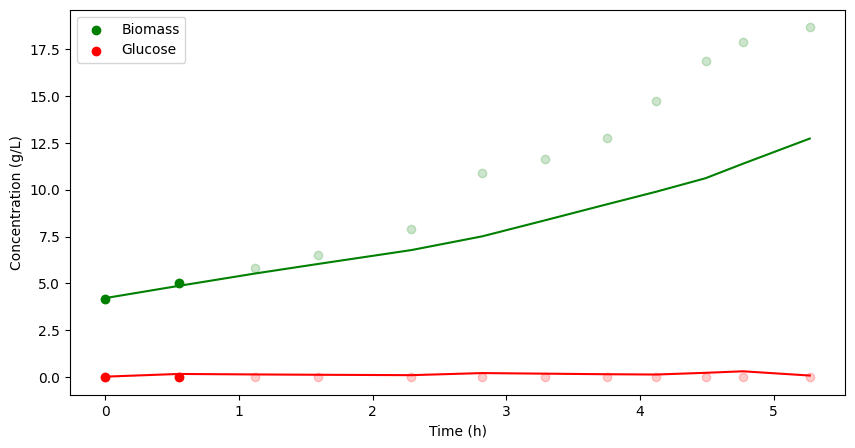

************************************************************************
************************************************************************
Biomass error: 0.2707
Glucose error: 0.1350
Real Biomass: 5.8000 || Predicted Biomass: 5.5293
Real Glucose: 0.0130 || Predicted Glucose: 0.1480
Biomass MSE: 14.7078
Glucose MSE: 0.0286


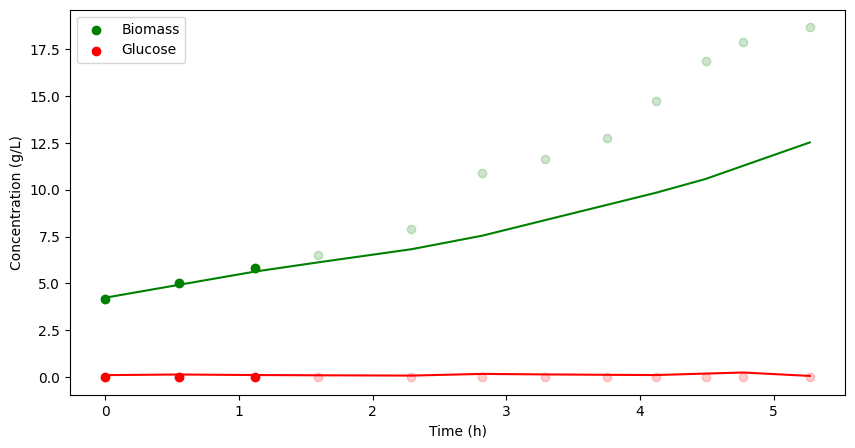

************************************************************************
************************************************************************
Biomass error: 0.3851
Glucose error: 0.0912
Real Biomass: 6.5071 || Predicted Biomass: 6.1221
Real Glucose: 0.0120 || Predicted Glucose: 0.1032
Biomass MSE: 15.1002
Glucose MSE: 0.0188


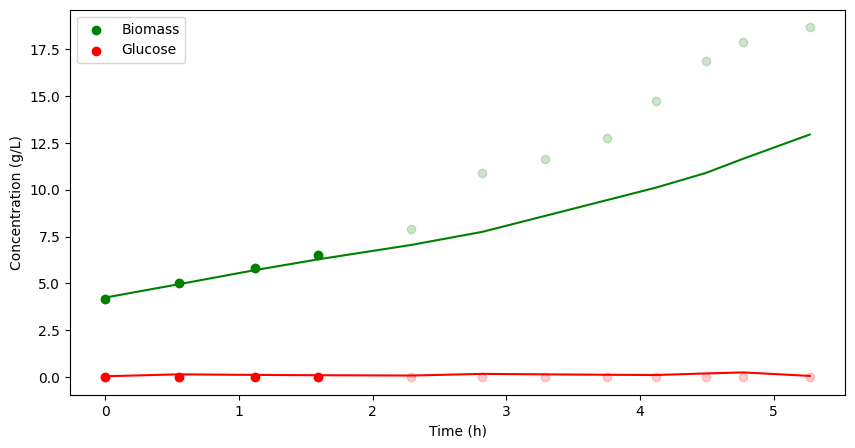

************************************************************************
************************************************************************
Biomass error: 0.8519
Glucose error: 0.0808
Real Biomass: 7.9071 || Predicted Biomass: 7.0552
Real Glucose: 0.0090 || Predicted Glucose: 0.0898
Biomass MSE: 13.3193
Glucose MSE: 0.0192


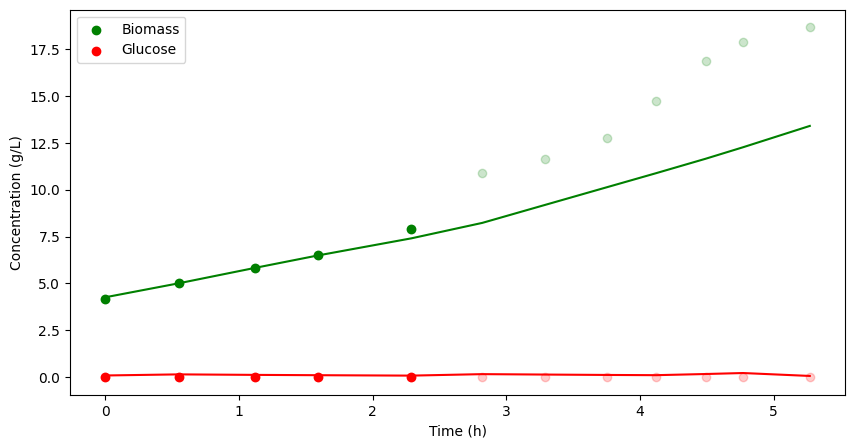

************************************************************************
************************************************************************
Biomass error: 2.6782
Glucose error: 0.1484
Real Biomass: 10.9071 || Predicted Biomass: 8.2290
Real Glucose: 0.0160 || Predicted Glucose: 0.1644
Biomass MSE: 10.1517
Glucose MSE: 0.0163


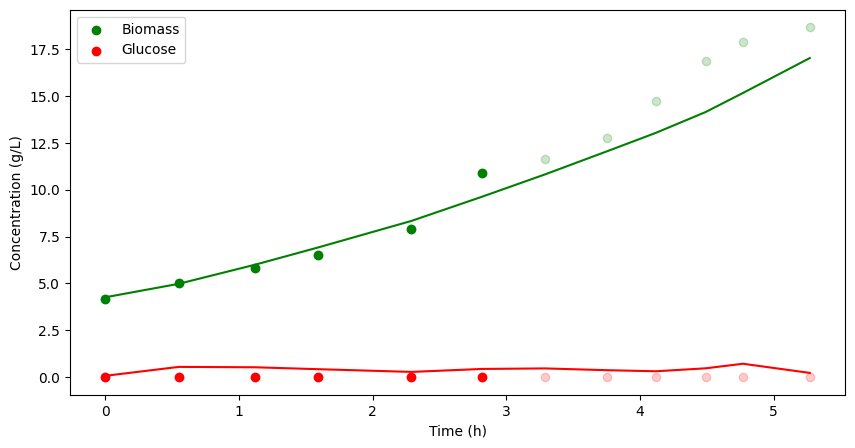

************************************************************************
************************************************************************
Biomass error: 0.8268
Glucose error: 0.4573
Real Biomass: 11.6429 || Predicted Biomass: 10.8161
Real Glucose: 0.0120 || Predicted Glucose: 0.4693
Biomass MSE: 1.9767
Glucose MSE: 0.1846


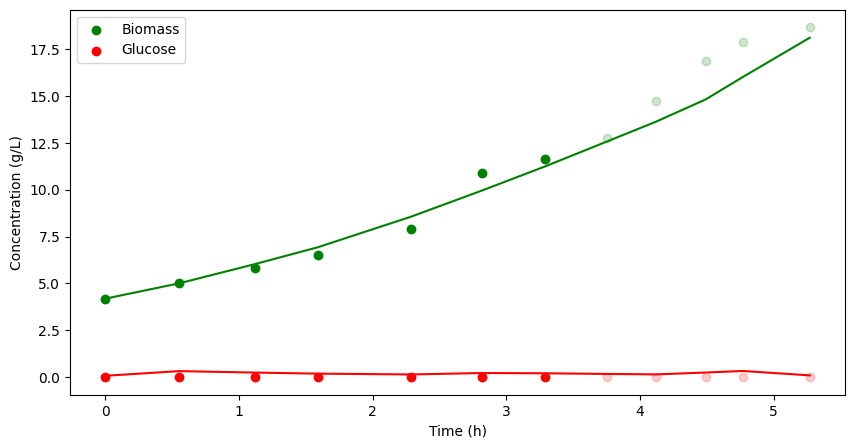

************************************************************************
************************************************************************
Biomass error: 0.2120
Glucose error: 0.1606
Real Biomass: 12.7726 || Predicted Biomass: 12.5606
Real Glucose: 0.0140 || Predicted Glucose: 0.1746
Biomass MSE: 0.9198
Glucose MSE: 0.0431


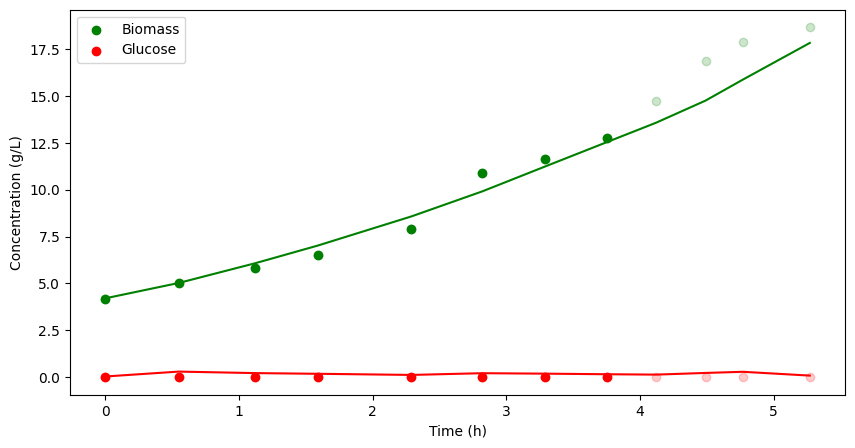

************************************************************************
************************************************************************
Biomass error: 1.1397
Glucose error: 0.1309
Real Biomass: 14.7095 || Predicted Biomass: 13.5698
Real Glucose: 0.0080 || Predicted Glucose: 0.1389
Biomass MSE: 1.0493
Glucose MSE: 0.0348


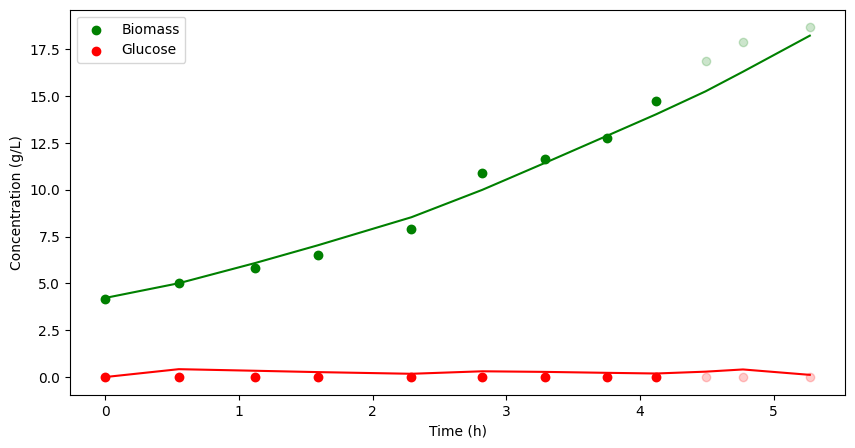

************************************************************************
************************************************************************
Biomass error: 1.6293
Glucose error: 0.2925
Real Biomass: 16.8714 || Predicted Biomass: 15.2421
Real Glucose: 0.0040 || Predicted Glucose: 0.2965
Biomass MSE: 0.6287
Glucose MSE: 0.0753


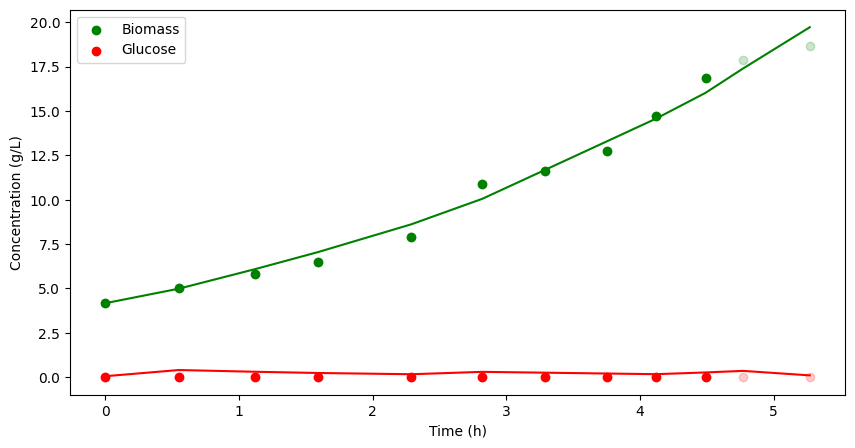

************************************************************************
************************************************************************
Biomass error: 0.4979
Glucose error: 0.3569
Real Biomass: 17.8905 || Predicted Biomass: 17.3925
Real Glucose: 0.0000 || Predicted Glucose: 0.3569
Biomass MSE: 0.3317
Glucose MSE: 0.0611


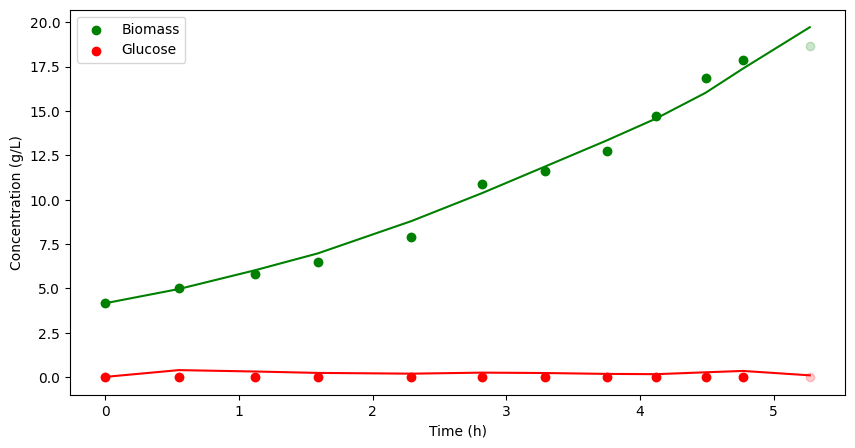

************************************************************************
************************************************************************
Biomass error: 1.0566
Glucose error: 0.1063
Real Biomass: 18.6619 || Predicted Biomass: 19.7185
Real Glucose: 0.0000 || Predicted Glucose: 0.1063
Biomass MSE: 0.3185
Glucose MSE: 0.0594


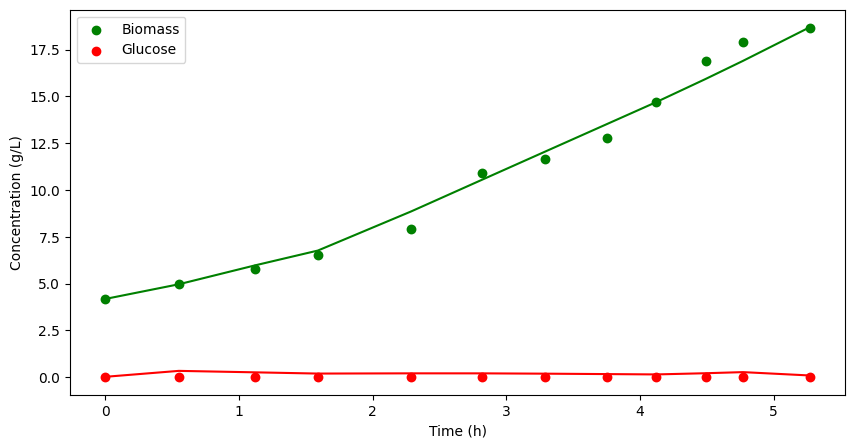

************************************************************************
************************************************************************
Biomass MSE: 0.3110
Glucose MSE: 0.0398


In [26]:
for i in range(2, len(full_df)+1):
    res = pd.read_csv(f'./temp/u_pred_{i}.csv')
    plot_predictions(full_df, res, i)
    validate_predictions(full_df, res, i)